In [15]:
import pandas as pd
import pyarrow
from dotenv import load_dotenv
import os
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd
from shapely import wkt
from shapely.affinity import translate, scale
from PIL import Image, ImageDraw

file_path = os.getenv('FILE_PATH')
print(file_path)

/home/koendesi/Desktop/Data_Matrixian/


In [16]:
df_sample = pd.read_parquet(file_path + "detailed_woning_type_sample.parquet")
df = pd.read_csv(file_path + "bag_image_summary.csv", dtype="string")
df_joined = pd.merge(df_sample, df, how="left", right_on="bag_id", left_on="bag_nummeraanduidingid")
df_sample_with_urls = df_joined[df_joined["frontview_exists"].notna()]
print(os.path.abspath(file_path + "sample_with_urls.csv"))
print(df_sample_with_urls.columns)


/home/koendesi/Desktop/Data_Matrixian/sample_with_urls.csv
Index(['bag_nummeraanduidingid', 'source_data_result_id', 'special_house_type',
       'woningtype', 'straatnaam', 'postcode', 'huisnr', 'huisnr_bag_letter',
       'huisnr_bag_toevoeging', 'plaatsnaam', 'opp_pand', 'oppervlakte',
       'build_year', 'build_type', 'is_monument', 'is_protected',
       'source_data_timestamp', 'geometry', 'random_rank', 'bag_id',
       'num_funda_images', 'frontview_exists', 'frontview_funda_url',
       'frontview_google_url', 'frontview_funda_in_business_url'],
      dtype='object')


In [17]:
df_sample_with_urls = df_sample_with_urls.drop(columns=[
    'bag_nummeraanduidingid', 'source_data_result_id', 'special_house_type',
    'straatnaam', 'postcode', 'huisnr', 'huisnr_bag_letter',
    'huisnr_bag_toevoeging', 'plaatsnaam', 'opp_pand', 'oppervlakte',
    'build_year', 'build_type', 'is_monument', 'is_protected',
    'source_data_timestamp', 'random_rank', 'bag_id',
    'num_funda_images', 'frontview_exists', 'frontview_funda_url',
    'frontview_google_url', 'frontview_funda_in_business_url'
])

print(df_sample_with_urls.columns)

Index(['woningtype', 'geometry'], dtype='object')


In [18]:
df_sample_with_urls['geometry'] = df_sample_with_urls['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df_sample_with_urls, geometry='geometry')

In [19]:
with pd.option_context('display.max_colwidth', None, 'display.width', None):
    print(df_sample_with_urls.head())

            woningtype  \
0  2-onder-1-kapwoning   
1  2-onder-1-kapwoning   
2  2-onder-1-kapwoning   
3  2-onder-1-kapwoning   
4  2-onder-1-kapwoning   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 geometry  
0                                                                                                                                                                                                                                                                                                                               POLYGON ((104905.322 499819.187

In [20]:
df_sample_with_urls['num_vertices'] = df_sample_with_urls['geometry'].apply(lambda g: len(g.exterior.coords))

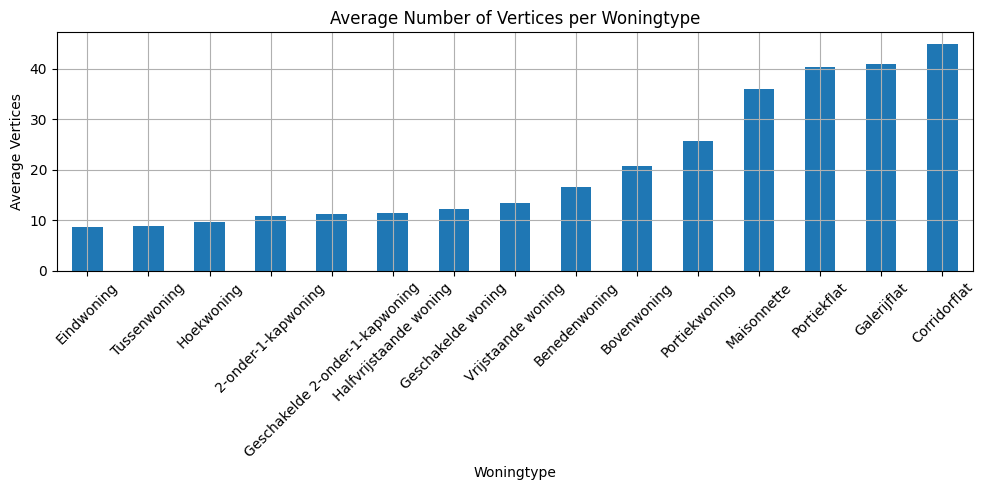

In [21]:
avg_vertices = df_sample_with_urls.groupby("woningtype")["num_vertices"].mean()

plt.figure(figsize=(10, 5))
avg_vertices.sort_values().plot(kind="bar")
plt.title("Average Number of Vertices per Woningtype")
plt.xlabel("Woningtype")
plt.ylabel("Average Vertices")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:


def normalize_polygon(geom):
    if geom and geom.exterior:
        coords = list(geom.exterior.coords)
        x0, y0 = coords[0]  # Reference point

        # Subtract first point from all points
        shifted_coords = [(x - x0, y - y0) for x, y in coords]
        new_geom = Polygon(shifted_coords)

        return x0, y0, new_geom
    else:
        return None, None, geom

# Apply normalization
df_sample_with_urls["cor_x"], df_sample_with_urls["cor_y"], df_sample_with_urls["geometry"] = zip(
    *df_sample_with_urls["geometry"].apply(normalize_polygon)
)


In [23]:
with pd.option_context('display.max_colwidth', None, 'display.width', None):
    print(df_sample_with_urls.head())

            woningtype  \
0  2-onder-1-kapwoning   
1  2-onder-1-kapwoning   
2  2-onder-1-kapwoning   
3  2-onder-1-kapwoning   
4  2-onder-1-kapwoning   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 geometry  \
0                                                                             

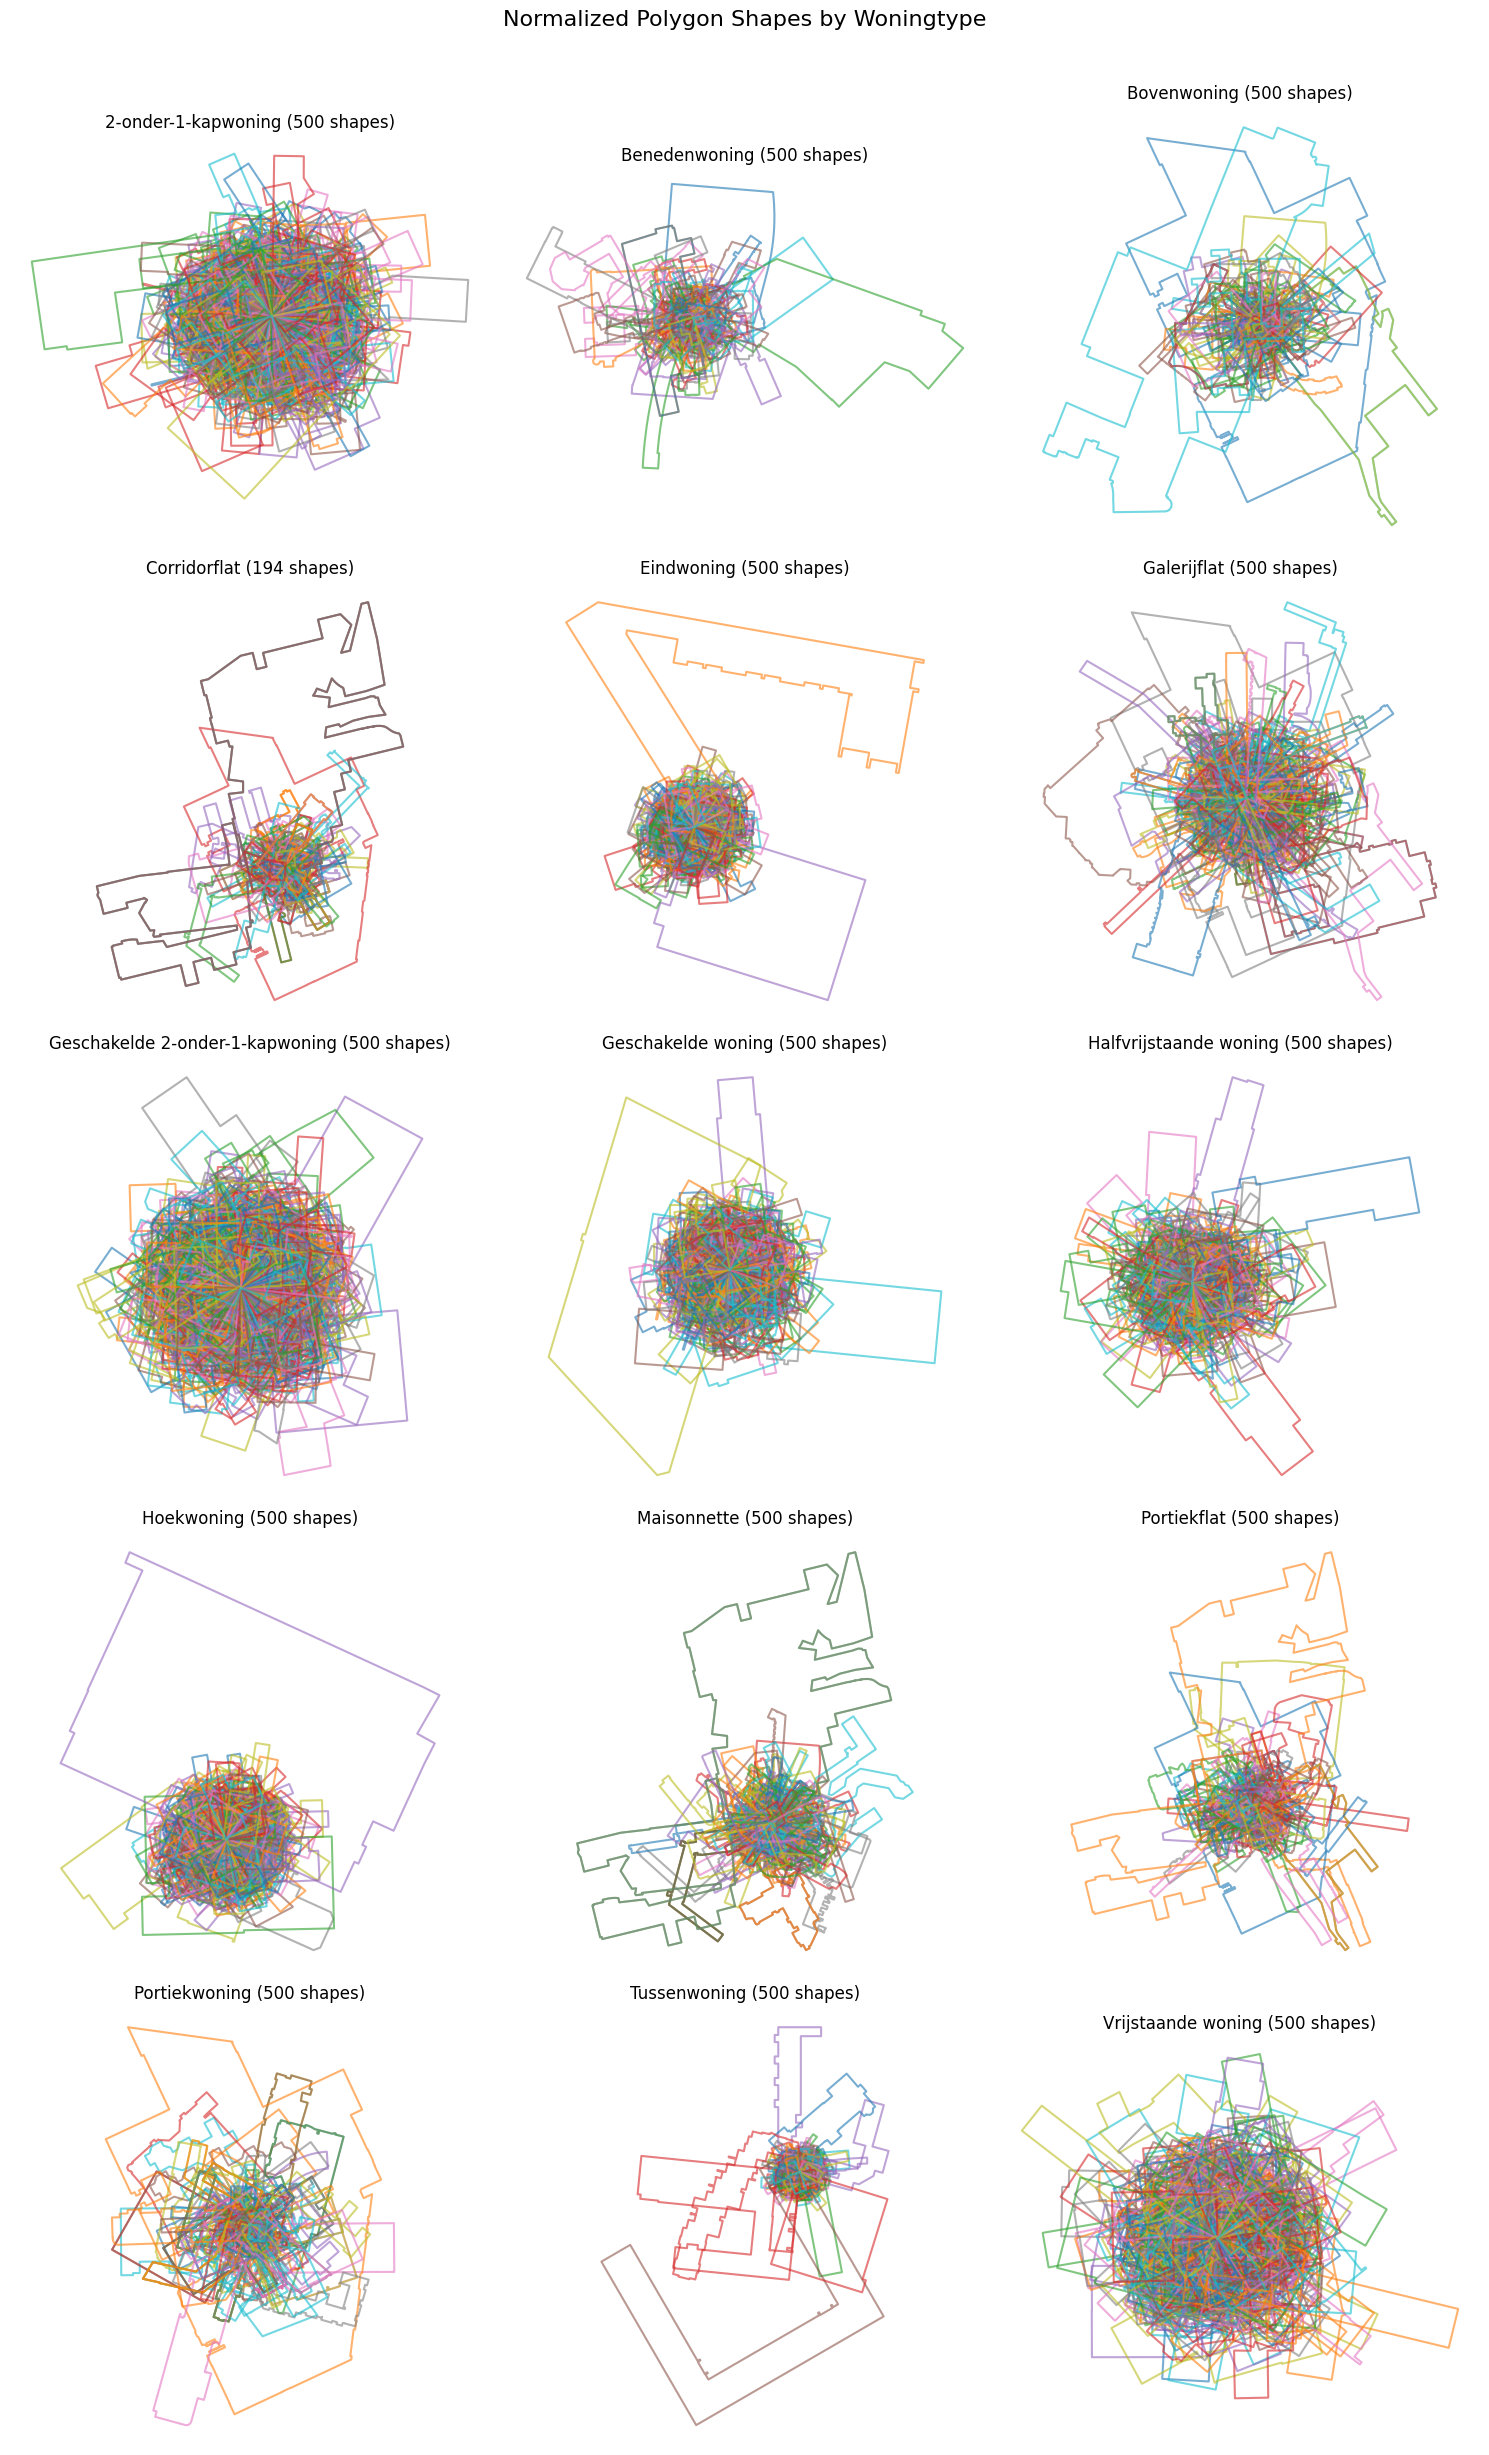

In [24]:
# Group by woningtype
groups = df_sample_with_urls.groupby("woningtype")
n = len(groups)
cols = 3  # number of columns in the grid
rows = math.ceil(n / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
axes = axes.flatten()  # Flatten in case of single row

# Plot each woningtype in its own subplot
for ax, (woningtype, group) in zip(axes, groups):
    for _, row in group.iterrows():
        x, y = row["geometry"].exterior.xy
        ax.plot(x, y, alpha=0.6)
    ax.set_title(f"{woningtype} ({len(group)} shapes)")
    ax.set_aspect("equal")
    ax.axis('off')  # Optional: clean look

# Hide any unused subplots
for ax in axes[n:]:
    ax.axis('off')

plt.suptitle("Normalized Polygon Shapes by Woningtype", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


In [25]:
# Add a column for number of vertices in each polygon
df_sample_with_urls["num_vertices"] = df_sample_with_urls["geometry"].apply(
    lambda geom: len(geom.exterior.coords) if geom and geom.exterior else 0
)


/tmp/ipykernel_37784/1378732135.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_q = df_sample_with_urls.groupby(["vertex_bin_quantile", "woningtype"]).size().unstack(fill_value=0)


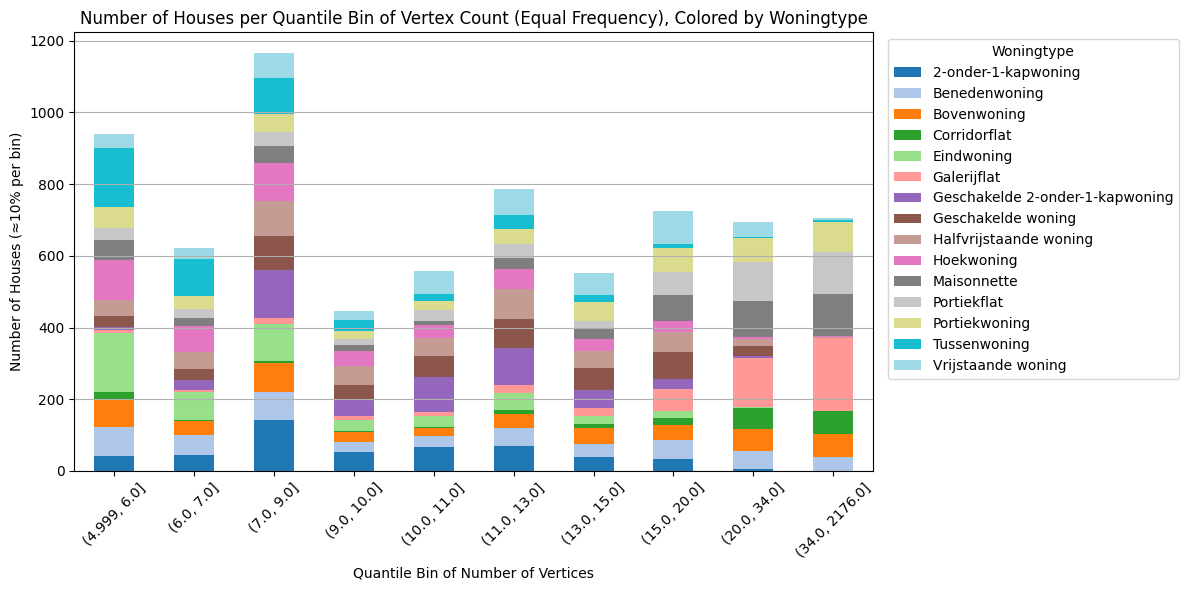

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Quantile binning (each bin ≈ 10% of houses)
df_sample_with_urls["vertex_bin_quantile"] = pd.qcut(
    df_sample_with_urls["num_vertices"],
    q=10,  # 10 bins for 10%
    duplicates='drop'  # handles non-unique bins if needed
)

# Step 2: Group by bin and woningtype
binned_q = df_sample_with_urls.groupby(["vertex_bin_quantile", "woningtype"]).size().unstack(fill_value=0)

# Step 3: Plot
binned_q.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="tab20")

plt.title("Number of Houses per Quantile Bin of Vertex Count (Equal Frequency), Colored by Woningtype")
plt.xlabel("Quantile Bin of Number of Vertices")
plt.ylabel("Number of Houses (≈10% per bin)")
plt.xticks(rotation=45)
plt.legend(title="Woningtype", bbox_to_anchor=(1.01, 1), loc="upper left")
plt.tight_layout()
plt.grid(axis='y')
plt.show()


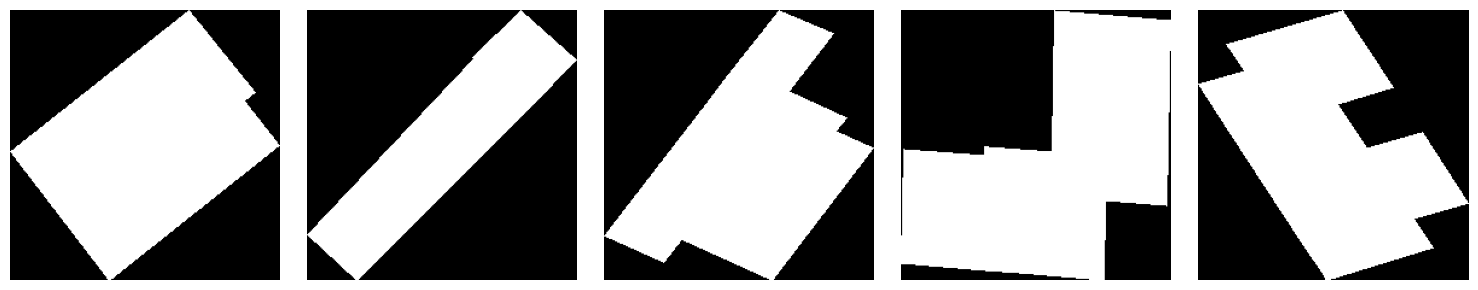

In [28]:
def rasterize_polygon(geom, size=224):
    # Normalize geometry to image space
    bounds = geom.bounds
    geom = translate(geom, xoff=-bounds[0], yoff=-bounds[1])
    scale_x = size / (bounds[2] - bounds[0] + 1e-8)
    scale_y = size / (bounds[3] - bounds[1] + 1e-8)
    geom = scale(geom, xfact=scale_x, yfact=scale_y, origin=(0, 0))

    # Create image mask
    img = Image.new("L", (size, size), 0)
    draw = ImageDraw.Draw(img)
    coords = [(x, size - y) for x, y in geom.exterior.coords]  # flip y-axis
    draw.polygon(coords, outline=1, fill=1)
    return np.array(img)

N = 5
sample_geoms = df_sample_with_urls["geometry"].head(N).tolist()
sample_images = [rasterize_polygon(g) for g in sample_geoms]

fig, axes = plt.subplots(1, len(sample_images), figsize=(3*N, 3))
for ax, img in zip(axes, sample_images):
    ax.imshow(img, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()
